<a href="https://colab.research.google.com/github/xhxuciedu/CS284A/blob/master/covid_19_severity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload github code and latest data; might take a while (~20 minutes on colab)

More information:
* https://github.com/Yu-Group/covid19-severity-prediction
* https://covidseverity.com/

In [1]:
!git clone https://github.com/Yu-Group/covid19-severity-prediction.git

Cloning into 'covid19-severity-prediction'...
remote: Enumerating objects: 469968, done.
remote: Total 469968 (delta 0), reused 0 (delta 0), pack-reused 469968
Receiving objects: 100% (469968/469968), 3.35 GiB | 27.35 MiB/s, done.
Resolving deltas: 100% (465643/465643), done.
Checking out files: 100% (481/481), done.


In [21]:
import sys
sys.path.append('/content/covid19-severity-prediction')
sys.path.append('/content/covid19-severity-prediction/modeling')

In [30]:
%cd covid19-severity-prediction/

assets	     docs	       _includes   load_data.py      readme.md
CNAME	     engineer_data.py  index.html  modeling	     requirements.txt
_config.yml  functions	       _layouts    __pycache__	     results
data	     ghostdriver.log   LICENSE	   quickstart.ipynb  viz


In [19]:
!ls

assets	     docs	       _includes   load_data.py      readme.md
CNAME	     engineer_data.py  index.html  modeling	     requirements.txt
_config.yml  functions	       _layouts    __pycache__	     results
data	     ghostdriver.log   LICENSE	   quickstart.ipynb  viz


In [22]:
!pip install adjustText

In [23]:
import bokeh
bokeh.sampledata.download()

Using data directory: /root/.bokeh/data
Skipping 'CGM.csv' (checksum match)
Skipping 'US_Counties.zip' (checksum match)
Skipping 'us_cities.json' (checksum match)
Skipping 'unemployment09.csv' (checksum match)
Skipping 'AAPL.csv' (checksum match)
Skipping 'FB.csv' (checksum match)
Skipping 'GOOG.csv' (checksum match)
Skipping 'IBM.csv' (checksum match)
Skipping 'MSFT.csv' (checksum match)
Skipping 'WPP2012_SA_DB03_POPULATION_QUINQUENNIAL.zip' (checksum match)
Skipping 'gapminder_fertility.csv' (checksum match)
Skipping 'gapminder_population.csv' (checksum match)
Skipping 'gapminder_life_expectancy.csv' (checksum match)
Skipping 'gapminder_regions.csv' (checksum match)
Skipping 'world_cities.zip' (checksum match)
Skipping 'airports.json' (checksum match)
Skipping 'movies.db.zip' (checksum match)
Skipping 'airports.csv' (checksum match)
Skipping 'routes.csv' (checksum match)
Skipping 'haarcascade_frontalface_default.xml' (checksum match)


In [122]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from viz import viz_interactive, viz_static, viz_map
from bokeh.plotting import figure, show, output_notebook, output_file, save
import load_data
from fit_and_predict import add_preds
import json
import datetime
from functions import emerging_index

## Load county level data

In [25]:
df = load_data.load_county_level()
df = df.sort_values('tot_deaths', ascending=False)
important_vars = load_data.important_keys(df)
print(df.keys())
df['tot_deaths_per_capita'] = df['tot_deaths'] / df['PopulationEstimate2018']
df['tot_cases_per_capita'] = df['tot_cases'] / df['PopulationEstimate2018']

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully
Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE',
       ...
       '#Deaths_10-27-2020', '#Deaths_10-28-2020', '#Deaths_10-29-2020',
       '#Deaths_10-30-2020', 'deaths', 'cases', 'tot_deaths', 'tot_cases',
       'neighbor_deaths', 'neighbor_cases'],
      dtype='object', length=659)


In [31]:
df.columns

Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE',
       ...
       '#Deaths_10-29-2020', '#Deaths_10-30-2020', 'deaths', 'cases',
       'tot_deaths', 'tot_cases', 'neighbor_deaths', 'neighbor_cases',
       'tot_deaths_per_capita', 'tot_cases_per_capita'],
      dtype='object', length=661)

Text(0, 0.5, 'num deaths')

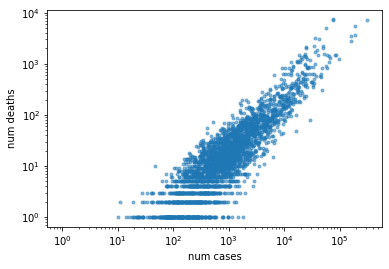

In [32]:
plt.loglog(df['tot_cases'], df['tot_deaths'], '.', alpha=0.5)
plt.xlabel('num cases')
plt.ylabel('num deaths')

In [27]:
df[['tot_deaths', 'tot_cases', 'StateName', 'CountyName']].head(10)

,tot_deaths,tot_cases,StateName,CountyName
1843,7400,75779,NY,Kings
1860,7294,77213,NY,Queens
199,7056,306327,CA,Los Angeles
602,5469,186405,IL,Cook
1822,4992,55661,NY,Bronx
3135,3643,185552,FL,Miami-Dade
98,3577,157728,AZ,Maricopa
1850,3198,36400,NY,New York
1304,3055,41731,MI,Wayne
2615,2806,160984,TX,Harris


In [58]:
df[df['StateName']=='CA'][['tot_deaths', 'tot_cases', 'StateName', 'CountyName']].head(10)

,tot_deaths,tot_cases,StateName,CountyName
199,7056,306327,CA,Los Angeles
210,1475,59718,CA,Orange
213,1319,68050,CA,Riverside
216,1074,64367,CA,San Bernardino
217,888,56369,CA,San Diego
214,500,26185,CA,Sacramento
219,494,22106,CA,San Joaquin
181,463,23775,CA,Alameda
190,443,31321,CA,Fresno
195,423,34308,CA,Kern


## Pull out data on Orange County, CA

In [46]:
# data on Orange County, CA
df[(df['StateName']=='CA') & (df['CountyName']=='Orange')]

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,#Deaths_09-29-2020,#Deaths_09-30-2020,#Deaths_10-01-2020,#Deaths_10-02-2020,#Deaths_10-03-2020,#Deaths_10-04-2020,#Deaths_10-05-2020,#Deaths_10-06-2020,#Deaths_10-07-2020,#Deaths_10-08-2020,#Deaths_10-09-2020,#Deaths_10-10-2020,#Deaths_10-11-2020,#Deaths_10-12-2020,#Deaths_10-13-2020,#Deaths_10-14-2020,#Deaths_10-15-2020,#Deaths_10-16-2020,#Deaths_10-17-2020,#Deaths_10-18-2020,#Deaths_10-19-2020,#Deaths_10-20-2020,#Deaths_10-21-2020,#Deaths_10-22-2020,#Deaths_10-23-2020,#Deaths_10-24-2020,#Deaths_10-25-2020,#Deaths_10-26-2020,#Deaths_10-27-2020,#Deaths_10-28-2020,#Deaths_10-29-2020,#Deaths_10-30-2020,deaths,cases,tot_deaths,tot_cases,neighbor_deaths,neighbor_cases,tot_deaths_per_capita,tot_cases_per_capita
210,06059,6.0,59.0,Orange,CA,California,33.716956,-117.753271,33.733953,-117.86288,West,Pacific,1.0,3185968.0,1574674.0,1615726.0,0.493566,456229.0,3807.7,3010232.0,36.2,517276.0,441129.0,501.0,7.8,133.0,35.2,9.311197,35.15,37487.0,13095.0,8.0,24.0,651.0,1.202728,98332.0,93359.0,101577.0,97192.0,107446.0,...,1249,1268,1275,1281,1286,1286,1287,1289,1292,1306,1316,1340,1341,1341,1341,1360,1391,1401,1409,1409,1410,1412,1423,1434,1440,1444,1447,1447,1454,1467,1468,1475,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1475,59718,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...",0.000463,0.018744


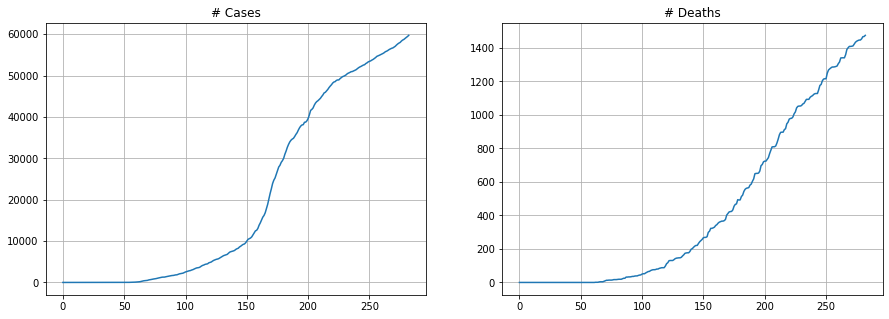

In [57]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(df[(df['StateName']=='CA') & (df['CountyName']=='Orange')]['cases'].values[0])
ax[1].plot(df[(df['StateName']=='CA') & (df['CountyName']=='Orange')]['deaths'].values[0])

ax[0].set_title('# Cases')
ax[1].set_title('# Deaths')
for a in ax:
  a.grid()

## Data on number of total deaths

Text(0.5, 0, 'Counties')

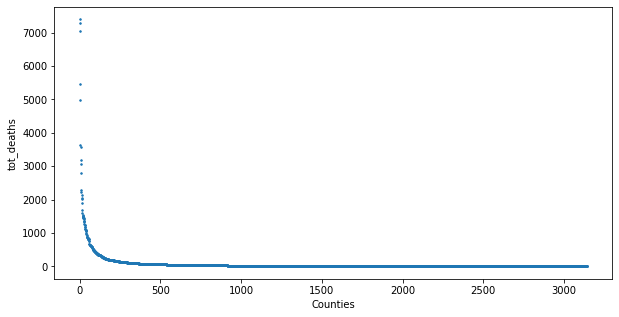

In [60]:
# s = f'Predicted Deaths {2}-day' # tot_deaths
s = 'tot_deaths'
plt.figure(figsize=(10, 5))
plt.plot(df[s].values, '.', ms=3)
plt.ylabel(s)
plt.xlabel('Counties')
#plt.yscale('log')
#plt.tight_layout()
#plt.show()

In [65]:
# rank counties based on deaths
df.sort_values(s, ascending=False)[['StateName','CountyName','tot_cases','tot_deaths']].head(10)

,StateName,CountyName,tot_cases,tot_deaths
1843,NY,Kings,75779,7400
1860,NY,Queens,77213,7294
199,CA,Los Angeles,306327,7056
602,IL,Cook,186405,5469
1822,NY,Bronx,55661,4992
3135,FL,Miami-Dade,185552,3643
98,AZ,Maricopa,157728,3577
1850,NY,New York,36400,3198
1304,MI,Wayne,41731,3055
2615,TX,Harris,160984,2806


In [73]:
df[['StateName','tot_deaths','tot_cases','PopulationEstimate2018']].groupby('StateName').sum().sort_values('tot_deaths',ascending=False).head(10)

,tot_deaths,tot_cases,PopulationEstimate2018
StateName,,,
NY,33126,505431,19542209.0
TX,17924,905843,28701845.0
CA,17627,928623,39557045.0
FL,16720,798430,21299325.0
NJ,16339,236001,8908520.0
MA,9970,162819,6902149.0
IL,9711,402322,12741080.0
PA,8784,205517,12807060.0
GA,7762,341496,10519475.0


## Aligned plots of the numbers of cases and deaths

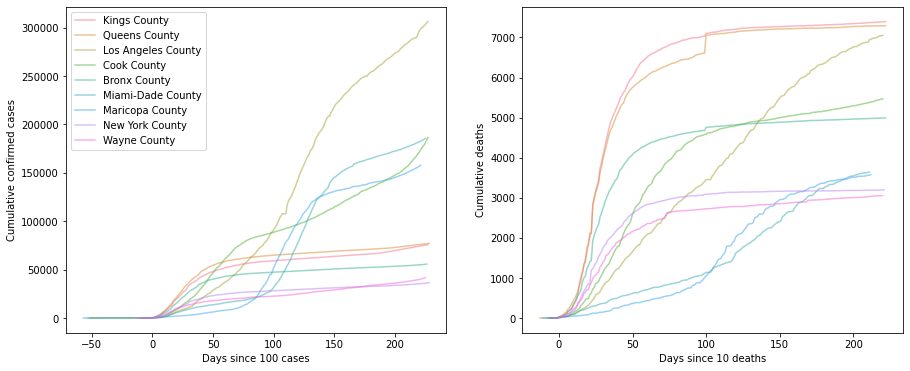

In [86]:
R, C = 1, 2
NUM_COUNTIES = 9
fig, ax = plt.subplots(1,2, figsize=(15, 6))
# cs = sns.diverging_palette(20, 220, n=NUM_COUNTIES)
cs = sns.color_palette("husl", NUM_COUNTIES)
for i in range(NUM_COUNTIES):
    row = df.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    ax[0].plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'] + ' County', color=cs[i])
    #     plt.yscale('log')
    ax[0].set_ylabel('Cumulative confirmed cases')
    ax[0].set_xlabel(f'Days since {CASES_ALIGNMENT} cases')
    ax[0].legend()
    
    ax[1].plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color=cs[i])
    #     plt.yscale('log')
    ax[1].set_ylabel('Cumulative deaths')
    ax[1].set_xlabel(f'Days since {DEATHS_ALIGNMENT} deaths')


# plt.tight_layout()
# plt.show()

## Correlation between variables

In [88]:
d = df[[k for k in important_vars if not 'PopMale' in k and not 'PopFmle' in k and not 'MortalityAge' in k and not 'PopTotal' in k] + 
        ['tot_cases', 'tot_cases_per_capita', 'tot_deaths', 'tot_deaths_per_capita']]

In [89]:
d.head(5)

,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,tot_cases,tot_cases_per_capita,tot_deaths,tot_deaths_per_capita
1843,Northeast,Middle Atlantic,1.0,2582830.0,0.473792,356714.0,35369.2,2504700.0,34.1,386673.0,309657.0,635.0,9.7,195.8,19.5,13.840802,23.05,35442.0,9307.0,6.0,12.0,318.0,4.541512,926.215538,737506.0,737500.0,737497.0,737502.0,737500.0,737500.0,737500.0,737495.0,0.8153,NaN,NaN,NaN,75779,0.029340,7400,0.002865
1860,Northeast,Middle Atlantic,1.0,2278906.0,0.484694,354809.0,20553.6,2230722.0,37.2,374573.0,308099.0,411.0,10.2,180.0,22.2,12.427777,24.13,16874.0,7009.0,5.0,6.0,129.0,3.463349,841.962329,737506.0,737500.0,737497.0,737502.0,737500.0,737500.0,737500.0,737495.0,0.6201,NaN,NaN,NaN,77213,0.033882,7294,0.003201
199,West,Pacific,1.0,10105518.0,0.492924,1343960.0,2419.6,9818605.0,34.8,1530126.0,1276832.0,2515.0,8.1,150.8,33.9,10.847678,34.94,157325.0,36517.0,22.0,76.0,2126.0,3.201541,3505.509038,737503.0,737503.0,737503.0,737503.0,737499.0,737499.0,737500.0,737495.0,0.7682,NaN,NaN,NaN,306327,0.030313,7056,0.000698
602,Midwest,East North Central,1.0,5180493.0,0.485603,743329.0,5495.1,5194675.0,35.3,845162.0,686929.0,1166.0,9.0,175.1,38.7,13.776183,41.02,111488.0,26136.0,24.0,46.0,1606.0,3.556127,2474.644934,737505.0,737502.0,737502.0,737501.0,737502.0,737502.0,737500.0,737495.0,0.6755,NaN,NaN,NaN,186405,0.035982,5469,0.001056
1822,Northeast,Middle Atlantic,1.0,1432132.0,0.471601,181313.0,32903.3,1385108.0,32.8,216750.0,159057.0,365.0,12.3,201.3,24.7,15.921169,31.58,34923.0,4813.0,6.0,6.0,270.0,9.356457,576.134443,737506.0,737500.0,737497.0,737502.0,737500.0,737500.0,737500.0,737495.0,0.9927,NaN,NaN,NaN,55661,0.038866,4992,0.003486


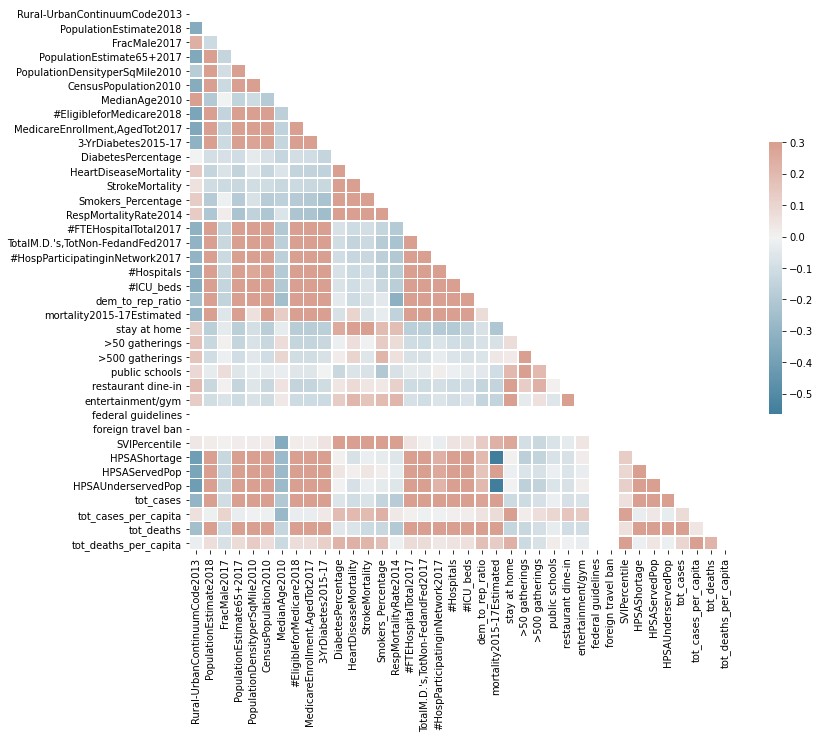

In [91]:
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

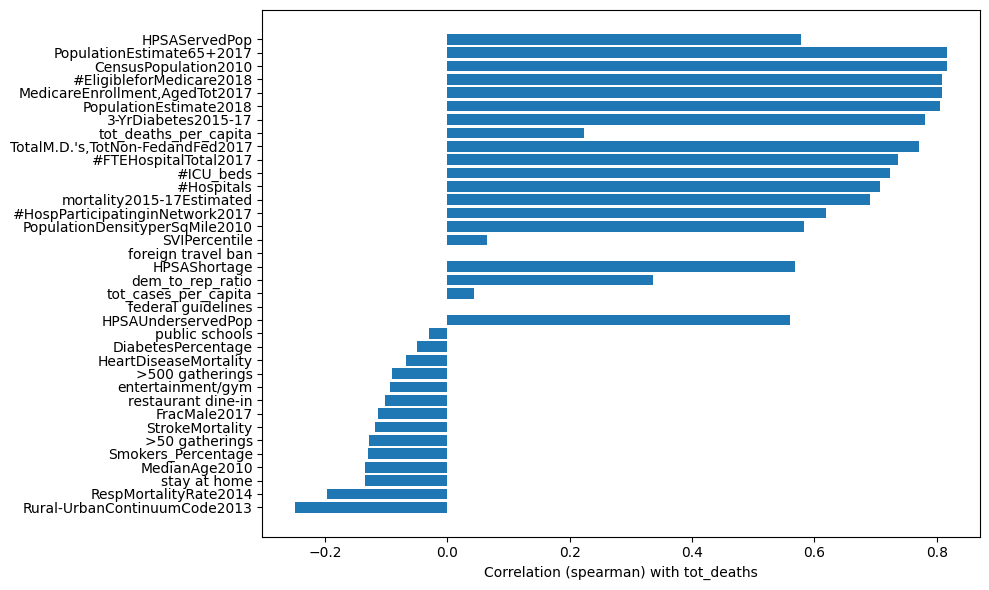

In [95]:
corrs = d.corr()
keys = np.array(corrs.index)
k = np.where(keys == 'tot_deaths')[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=100, figsize=(10, 6))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with tot_deaths')
plt.tight_layout()
# plt.savefig('results/correlations.png')

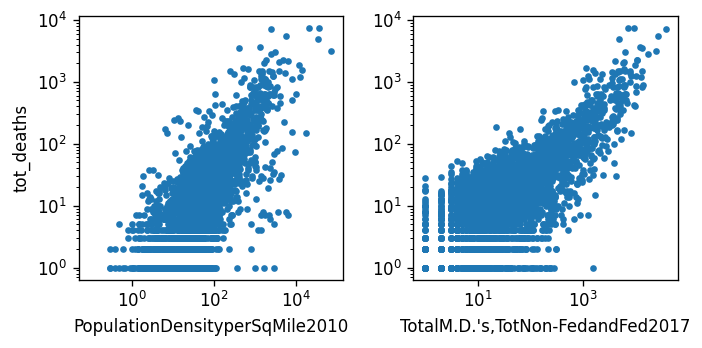

In [98]:
ks = ['PopulationDensityperSqMile2010', "TotalM.D.'s,TotNon-FedandFed2017"]
R, C = 1, len(ks)
plt.figure(dpi=120, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('tot_deaths')
    plt.loglog(d[ks[c]], d['tot_deaths'], '.')
    plt.xlabel(ks[c])

plt.tight_layout()

## Predictions

Prediction cases or deaths in the future.  Chose NUM_DAYS =1, 2, 3, ...

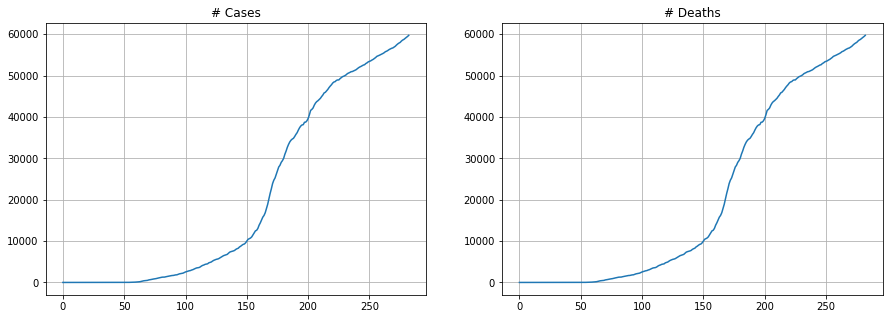

In [102]:
# use data from Orange, CA for an example
fig,ax = plt.subplots(1,2,figsize=(15,5))
OC_cases = df[(df['StateName']=='CA') & (df['CountyName']=='Orange')]['cases'].values[0]
OC_deaths = df[(df['StateName']=='CA') & (df['CountyName']=='Orange')]['cases'].values[0]
ax[0].plot(OC_cases)
ax[1].plot(OC_deaths)

ax[0].set_title('# Cases')
ax[1].set_title('# Deaths')
for a in ax:
  a.grid()

### linear model
Use the data from the past T days to estimate the current number:

$$
x_t = \theta_0 + \theta_1 x_{t-1} + \theta_2 x_{t-2} + \cdots + \theta_T x_{t-T}
$$

Let's try $T=10$ days and use linear regression to estimate the regression coefficients $\theta_0, \theta_1, \cdots, \theta_T$.

In [193]:
# get data first
# convert a time series to a data matrix
def get_data_matrix(data, n):
  # n = 10; the number of past days, the input dimension
  size = len(data)
  m = size-n-1
  #print(n,m,size)
  
  tmp = []
  for i in range(m): # get the latest 100
    tmp.append(data[size-i-n-1:size-i])
  tmp = np.stack(tmp)
  return tmp[:,:-1], tmp[:,-1]-tmp[:,-2]

In [194]:
# get training data X, Y
X, y = get_data_matrix(OC_cases, 10)

In [195]:
X.shape, y.shape

((272, 10), (272,))

## Split data in train and test

In [196]:
from sklearn.model_selection import train_test_split

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [198]:
X_train.shape, y_train.shape, X_test.shape

((182, 10), (182,), (90, 10))

In [210]:
# use sklearn linear regression
from sklearn.linear_model import LinearRegression

In [200]:
# learning parameters; fit data into the model
reg = LinearRegression().fit(X, y)

In [201]:
# find out learned coefficients and bias
print(reg.coef_)
print(reg.intercept_)

[-0.06510718  0.02625548 -0.03991175  0.19015182 -0.32430596  0.30492598
 -0.25186715  0.16564543 -0.61065229  0.60468425]
16.868721868346483


Text(0, 0.5, 'Prediction')

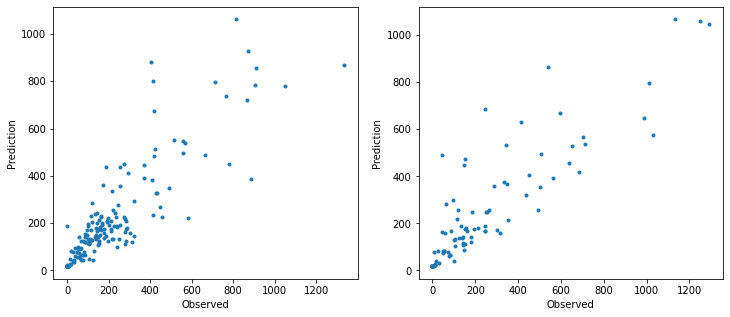

In [202]:
# making predictions
fig, ax = plt.subplots(1,2, figsize=(12,5))

# predictions on training data
ax[0].plot(y_train, reg.predict(X_train),'.')
ax[0].set_xlabel('Observed')
ax[0].set_ylabel('Prediction')

# predictions on test data
ax[1].plot(y_test, reg.predict(X_test),'.')
ax[1].set_xlabel('Observed')
ax[1].set_ylabel('Prediction')

# evaluate performance
Use sklearn metrics

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [205]:
import sklearn.metrics as metrics

In [208]:
# MSE
print('MSE: ', metrics.mean_squared_error(y_test, reg.predict(X_test)))

MSE:  20223.82031295429


In [209]:
# MSE
print('MSE: ', metrics.r2_score(y_test, reg.predict(X_test)))

MSE:  0.7719540980668629


In [211]:
# use sklearn linear classification
from sklearn.linear_model import LogisticRegression

In [229]:
# learning parameters; fit data into the classification model
clf = LogisticRegression().fit(X_train, y_train>100)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [1]:
np.sum(y_train>100)/len(y_train)

NameError: ignored

In [235]:
# traing accuracy
print('Training accuracy: ', metrics.accuracy_score(y_train>0, clf.predict(X_train)))

# test accuracy
print('Test accuracy: ', metrics.accuracy_score(y_test>0, clf.predict(X_test)))

Training accuracy:  0.945054945054945
Test accuracy:  0.9222222222222223


In [239]:
# generate more complete classification reprot
print(metrics.classification_report(y_test>0, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.58      0.78      0.67         9
        True       0.97      0.94      0.96        81

    accuracy                           0.92        90
   macro avg       0.78      0.86      0.81        90
weighted avg       0.94      0.92      0.93        90



In [242]:
metrics.confusion_matrix(y_test>0, clf.predict(X_test))

array([[ 7,  2],
       [ 5, 76]])